In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
from scipy.stats import spearmanr
from dateutil.relativedelta import relativedelta

## 定义需要的类和函数

In [2]:
#计算全市股票收益率
class ashareeodprice():
    def __init__(self,asharepath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/ashare_nost.csv') -> None:
        self.asharepath=asharepath
        self.ashare_data=None
    
    def read_data(self):
        self.ashare_data = pd.read_csv(self.asharepath, parse_dates=['TRADE_DT'],encoding='gbk')
        # self.data.sort_values('TRADE_DT', inplace=True)

    def get_data(self):
        return self.ashare_data

    def display_data(self):
        print(self.ashare_data)

    def calculate_return_for_stock(self, stock_code, start_date, end_date):
        """筛选特定日期"""
        # 将start_date转为datetime对象
        start_date = pd.to_datetime(start_date)
        # 计算start_date减去90天的日期
        cutoff_date = start_date - timedelta(days=90)
        
        # 计算每只股票的上市日期
        stock_listing_dates = self.ashare_data.groupby('S_INFO_WINDCODE')['TRADE_DT'].min().reset_index()
        stock_listing_dates.columns = ['S_INFO_WINDCODE', 'LISTING_DATE']

        # 筛除上市时间不足90天的新股
        if cutoff_date<pd.to_datetime('2023-01-03'):
            cutoff_date=pd.to_datetime('2023-01-03')
            stock_listing_dates = stock_listing_dates[stock_listing_dates['LISTING_DATE'] <= cutoff_date]
        else:
            stock_listing_dates = stock_listing_dates[stock_listing_dates['LISTING_DATE'] <= cutoff_date]

        # 筛选符合条件的股票代码
        valid_stocks = stock_listing_dates['S_INFO_WINDCODE']

        # 筛选特定股票和日期范围的数据
        filtered_data = self.ashare_data[
            (self.ashare_data['S_INFO_WINDCODE'].isin(valid_stocks)) &
            (self.ashare_data['S_INFO_WINDCODE'] == stock_code) &
            (self.ashare_data['TRADE_DT'] >= start_date) &
            (self.ashare_data['TRADE_DT'] <= end_date)
        ]
        if filtered_data.empty:
            return None
        start_price = filtered_data.iloc[0]['S_DQ_ADJCLOSE']
        end_price = filtered_data.iloc[-1]['S_DQ_ADJCLOSE']
        return (end_price - start_price) / start_price
    
    def calculate_returns_for_all_stocks(self, start_date, end_date):
        """计算所有股票在两个日期之间的收益率"""
        stock_codes = self.ashare_data['S_INFO_WINDCODE'].unique()
        returns = []
        for stock_code in tqdm(stock_codes):
            stock_return = self.calculate_return_for_stock(stock_code, start_date, end_date)
            if stock_return is not None:
                returns.append({'StockCode': stock_code, 'Return': stock_return})
        return pd.DataFrame(returns)
    
    def calculate_daily_returns(self,start_date, end_date):
        """计算每只股票的日频收益率"""
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        cutoff_date = start_date - timedelta(days=90)
        
        # 计算每只股票的上市日期
        stock_listing_dates = self.ashare_data.groupby('S_INFO_WINDCODE')['TRADE_DT'].min().reset_index()
        stock_listing_dates.columns = ['S_INFO_WINDCODE', 'LISTING_DATE']

        # 筛除上市时间不足90天的新股
        if cutoff_date < pd.to_datetime('2023-01-03'):
            cutoff_date = pd.to_datetime('2023-01-03')
            stock_listing_dates = stock_listing_dates[stock_listing_dates['LISTING_DATE'] <= cutoff_date]
        else:
            stock_listing_dates = stock_listing_dates[stock_listing_dates['LISTING_DATE'] <= cutoff_date]

        # 筛选符合条件的股票代码
        valid_stocks = stock_listing_dates['S_INFO_WINDCODE']

        # 筛选符合条件的股票和日期范围的数据
        filtered_data = self.ashare_data[
            (self.ashare_data['S_INFO_WINDCODE'].isin(valid_stocks)) &
            (self.ashare_data['TRADE_DT'] >= start_date) &
            (self.ashare_data['TRADE_DT'] <= end_date)
        ]
        # 计算日频收益率
        filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()

        # 删除含有NaN值的行
        filtered_data.dropna(subset=['Daily_Return'], inplace=True)

        return filtered_data[['S_INFO_WINDCODE', 'TRADE_DT', 'Daily_Return']]

    def rank_and_split_returns(self, returns_df):
        """对收益率进行排名并转换为分位数,前50%按升序排列,后50%按降序排列,并按照排名进行加权"""
        sorted_df = returns_df.sort_values(by='Return', ascending=False).copy()
        total_count = len(sorted_df)
        mid_point = total_count // 2

        top_50 = sorted_df.iloc[:mid_point]
        bottom_50 = sorted_df.iloc[mid_point:]

        top_50['Rank'] = top_50['Return'].rank(ascending=True)
        bottom_50['Rank'] = bottom_50['Return'].rank(ascending=False)
        
        top_50['Weight'] = top_50['Rank'] / (top_50['Rank'].sum() + bottom_50['Rank'].sum())
        bottom_50['Weight']  = bottom_50['Rank'] / (top_50['Rank'].sum() + bottom_50['Rank'].sum())
        top_50=top_50.set_index('StockCode')
        bottom_50=bottom_50.set_index('StockCode')
        sorted_df = pd.concat([top_50, bottom_50])
        sorted_df['Rank'] = sorted_df['Rank'].astype(int)
        return sorted_df, top_50, bottom_50



In [3]:
#计算rankmatrix
class fundportfolio():
    def __init__(self,portfoliopath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/fund_2303to2403.csv') -> None:
        self.portfoliopath=portfoliopath
        self.portfolio_data=None
        
    def read_data(self):
        self.portfolio_data = pd.read_csv(self.portfoliopath, parse_dates=['F_PRT_ENDDATE'])
        try:
            self.portfolio_data['F_PRT_ENDDATE'] = pd.to_datetime(self.portfolio_data['F_PRT_ENDDATE'], format='%Y%m%d')
        except Exception as e:
            print(f"Error converting F_PRT_ENDDATE to datetime: {e}")
            raise
        self.portfolio_data.sort_values('F_PRT_ENDDATE', inplace=True)

    def get_data(self):
        return self.portfolio_data

    def display_data(self):
        print(self.portfolio_data)
    
    def filter_data_by_enddate(self, enddate_str):
        """根据日期过滤数据"""
        if self.portfolio_data is None:
            raise ValueError("数据未加载，请先调用 read_data() 方法加载数据。")
        if not pd.api.types.is_datetime64_any_dtype(self.portfolio_data['F_PRT_ENDDATE']):
            raise TypeError("F_PRT_ENDDATE 列不是日期类型，请检查数据格式。")
        return self.portfolio_data[self.portfolio_data['F_PRT_ENDDATE'].dt.strftime('%Y-%m-%d') == enddate_str]

    def top_holdings_by_fund(self, fund_code, top_n=10):
        """选出特定基金持仓权重前top_n的股票"""
        fund_data = self.portfolio_data[self.portfolio_data['S_INFO_WINDCODE'] == fund_code]
        top_holdings = fund_data.sort_values(by='F_PRT_STKVALUETONAV', ascending=False).head(top_n)
        return top_holdings
    
    def remove_funds_with_hk_stocks(self):
        """删除持有港股的基金"""
        hk_stocks_funds = self.portfolio_data[self.portfolio_data['S_INFO_STOCKWINDCODE'].str.endswith('HK')]['S_INFO_WINDCODE'].unique()
        self.portfolio_data = self.portfolio_data[~self.portfolio_data['S_INFO_WINDCODE'].isin(hk_stocks_funds)]

    def top_holdings_for_all_funds(self, top_n=10):
        """选出所有基金持仓权重前top_n的股票"""
        self.remove_funds_with_hk_stocks()
        all_top_holdings = pd.DataFrame()
        fund_codes = self.portfolio_data['S_INFO_WINDCODE'].unique()
        for fund_code in fund_codes:
            top_holdings = self.top_holdings_by_fund(fund_code, top_n)
            all_top_holdings = pd.concat([all_top_holdings, top_holdings])
        return all_top_holdings
    
    def filter_and_top_holdings_for_all_funds(self, enddate_str, top_n=10):
        """筛选出指定日期的所有基金持仓权重前top_n的股票"""
        filtered_data = self.filter_data_by_enddate(enddate_str)
        self.portfolio_data = filtered_data  
        return self.top_holdings_for_all_funds(top_n)
    
    def create_rank_matrix(self,rawmatrix,top_50,bottom_50):

        matrix_raw=rawmatrix.pivot(index='S_INFO_STOCKWINDCODE',columns='S_INFO_WINDCODE',values='F_PRT_STKVALUETONAV')
        matrix_raw.fillna(0,inplace=True)
        top_50_id=pd.DataFrame(top_50.index)
        bottom_50_id=pd.DataFrame(bottom_50.index)
        top50_stocks = top_50_id['StockCode'].tolist()
        bottom50_stocks = bottom_50_id['StockCode'].tolist()
        top50_stocks = [stock for stock in top50_stocks if stock in matrix_raw.index]
        top50_df = matrix_raw.loc[top50_stocks]
        bottom50_stocks = [stock for stock in bottom50_stocks if stock in matrix_raw.index]
        bottom50_df = matrix_raw.loc[bottom50_stocks]
        quantile_top50_holdings = top50_df.rank(pct=True,method='average',axis=1)
        quantile_bottom50_holdings=bottom50_df.rank(pct=True,method='average',ascending=False,axis=1)
        rank=pd.concat([quantile_top50_holdings,quantile_bottom50_holdings])
        return rank
        

In [4]:
# 定义一个函数来计算每个基金的收益率
def calculate_return(group):
    # 找到期初净值和期末净值

    initial_nav = group.iloc[-1]['F_NAV_ADJUSTED']
    final_nav = group.iloc[0]['F_NAV_ADJUSTED']
    # 计算收益率
    return_rate = (final_nav/ initial_nav)-1 
    return pd.Series({'Longterm_Return_Fund': return_rate})



In [5]:
#计算基金收益率
class fundreturns:
    def __init__(self,fundreturnpath='/Users/chenjiayi/Desktop/陈佳懿_相关数据/new_7.23/ChinaMutualFundNAV_NEW.CSV') -> None:
        self.fundreturnpath=fundreturnpath
        self.fundreturn_data=[]
    
    def get_data(self):
        self.fundreturn_data = pd.read_csv(self.fundreturnpath,parse_dates=['PRICE_DATE'],dtype={'F_INFO_WINDCODE':str,'F_NAV_ADJUSTED':float},low_memory=False)
        self.fundreturn_data = self.fundreturn_data.dropna()
    
    def calculate_return_for_fund(self,start_date, end_date):
        """计算特定基金在报告期的收益率"""
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        filtered_data = self.fundreturn_data[
                                  (self.fundreturn_data['PRICE_DATE'] >= start_date)&
                                   (self.fundreturn_data['PRICE_DATE']<=end_date) ]

        if filtered_data.empty:
            return None
        # 使用 groupby 按基金编号分组，并应用计算收益率的函数
        returns = filtered_data.groupby('F_INFO_WINDCODE').apply(calculate_return).reset_index()

        return returns
    
    def calculate_return_rank_for_funds(self,start_date, end_date):
        """按照Fund_return升序排序并返回分位数"""
        df_sorted = self.calculate_returns_for_all_funds(start_date, end_date).sort_values(by='Fund_return', ascending=True).reset_index(drop=True)
        # df_sorted['Quantile'] = pd.qcut(df_sorted['Fund_return'], q=100, labels=False,duplicates='drop') / 100
        df_sorted['Quantile'] = df_sorted['Fund_return'].rank(pct=True,method='average')
        return df_sorted   
    
    def calculate_daily_returns_for_funds(self,start_date, end_date):
        filtered_data = self.fundreturn_data[
                            (self.fundreturn_data['PRICE_DATE'] >= start_date)&
                            (self.fundreturn_data['PRICE_DATE']<=end_date) ]
        # 确保数据按照基金代码和日期排序
        filtered_data.sort_values(by=['F_INFO_WINDCODE', 'PRICE_DATE'], inplace=True)
        filtered_data['Daily_Return_Fund'] = filtered_data.groupby('F_INFO_WINDCODE')['F_NAV_ADJUSTED'].pct_change()

        # 删除含有NaN值的行
        filtered_data.dropna(subset=['Daily_Return_Fund'], inplace=True)

        return filtered_data[['F_INFO_WINDCODE', 'PRICE_DATE', 'Daily_Return_Fund']]


In [6]:
#定义IR的计算方式，用于arregation func
def ir(series):
    return series.mean()/series.std()

In [7]:
#计算模拟收益率
def calculate_simulation_return(stock_daily_return,fund_holdings):
    merged_data = pd.merge(
        stock_daily_return,
        fund_holdings,
        left_on='S_INFO_WINDCODE',
        right_on='S_INFO_STOCKWINDCODE',
        how='inner'
    )
    # 计算每只基金的日收益率
    merged_data['Weighted_Return'] = merged_data['Daily_Return'] * merged_data['F_PRT_STKVALUETONAV'] / 100
    merged_data
    # 聚合每只基金的每日加权收益率
    fund_daily_returns = merged_data.groupby(['S_INFO_WINDCODE_y', 'TRADE_DT']).agg({'Weighted_Return': 'sum'}).reset_index()

    return fund_daily_returns

In [8]:
#计算超额收益与rankic
def calculate_excess(stock_daily_return,fund_holdings,fund_actual_daily_returns,fund_actual_longterm_return):
    fund_simulated_daily_returns=calculate_simulation_return(stock_daily_return,fund_holdings)
    returncalc=pd.merge(fund_actual_daily_returns,
                        fund_simulated_daily_returns,
                        left_on=['F_INFO_WINDCODE','PRICE_DATE'],
                        right_on=['S_INFO_WINDCODE_y','TRADE_DT'],
                        how='inner')
    returncalc['Excess_Return']=returncalc['Daily_Return_Fund']-returncalc['Weighted_Return']
    df=pd.DataFrame(returncalc.groupby('S_INFO_WINDCODE_y')['Excess_Return'].agg(ir))
    result=pd.merge(df,fund_actual_longterm_return,left_on='S_INFO_WINDCODE_y',right_on='F_INFO_WINDCODE')
    rankic=result['Excess_Return'].corr(result['Longterm_Return_Fund'],method='spearman')

    return rankic

## 进行测试

### T,T+3,T+4, topn=10

In [26]:
def calculate_rankic_and_save_results(start_date, end_date, output_file):
    results = []

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # 初始化日期
    current_date = start_date

    while current_date <= end_date:
        # 确定报告期
        if current_date.month <= 3:
            report_date = pd.to_datetime(f"{current_date.year-1}-12-31")
        elif current_date.month <= 6:
            report_date = pd.to_datetime(f"{current_date.year}-03-31")
        elif current_date.month <= 9:
            report_date = pd.to_datetime(f"{current_date.year}-06-30")
        else:
            report_date = pd.to_datetime(f"{current_date.year}-09-30")

        # 确定构建期和测试期
        construct_start = current_date
        construct_end = construct_start + relativedelta(months=3) - pd.DateOffset(days=1)
        test_start = construct_end + pd.DateOffset(days=1)
        test_end = test_start + relativedelta(months=1) - pd.DateOffset(days=1)

        # 确保时间线不超出
        if test_end > end_date:
            break

        print(f"报告期: {report_date.strftime('%Y-%m-%d')}")
        print(f"构建期: {construct_start.strftime('%Y-%m-%d')} 至 {construct_end.strftime('%Y-%m-%d')}")
        print(f"测试期: {test_start.strftime('%Y-%m-%d')} 至 {test_end.strftime('%Y-%m-%d')}")

        # 读取数据
        stock = ashareeodprice()
        stock.read_data()
        stock_daily_return = stock.calculate_daily_returns(construct_start, construct_end)

        fundportfolio1 = fundportfolio()
        fundportfolio1.read_data()
        holding = fundportfolio1.filter_and_top_holdings_for_all_funds(report_date.strftime('%Y-%m-%d'), top_n=10)

        fundreturn = fundreturns()
        fundreturn.get_data()
        fund_daily_returns_actual = fundreturn.calculate_daily_returns_for_funds(construct_start, construct_end)
        fund_longterm_returns_actual = fundreturn.calculate_return_for_fund(test_start, test_end)

        # 计算rankic
        rankic = calculate_excess(stock_daily_return, holding, fund_daily_returns_actual, fund_longterm_returns_actual)

        # 保存结果到df
        results.append({
            'Report_Date': report_date.strftime('%Y-%m-%d'),
            'Construct_Period': f"{construct_start.strftime('%Y-%m-%d')} to {construct_end.strftime('%Y-%m-%d')}",
            'Test_Period': f"{test_end.strftime('%Y-%m')}",
            'RankIC': rankic
        })

        # 滑到下一个月
        current_date += pd.DateOffset(months=1)

    # 保存结果到csv
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)


calculate_rankic_and_save_results('2023-04-01', '2024-04-30', 'rank_ic_results_8.6_2.0.csv')

报告期: 2023-03-31
构建期: 2023-04-01 至 2023-06-30
测试期: 2023-07-01 至 2023-07-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-03-31
构建期: 2023-05-01 至 2023-07-31
测试期: 2023-08-01 至 2023-08-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-03-31
构建期: 2023-06-01 至 2023-08-31
测试期: 2023-09-01 至 2023-09-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-06-30
构建期: 2023-07-01 至 2023-09-30
测试期: 2023-10-01 至 2023-10-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-06-30
构建期: 2023-08-01 至 2023-10-31
测试期: 2023-11-01 至 2023-11-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-06-30
构建期: 2023-09-01 至 2023-11-30
测试期: 2023-12-01 至 2023-12-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-09-30
构建期: 2023-10-01 至 2023-12-31
测试期: 2024-01-01 至 2024-01-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-09-30
构建期: 2023-11-01 至 2024-01-31
测试期: 2024-02-01 至 2024-02-29


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-09-30
构建期: 2023-12-01 至 2024-02-29
测试期: 2024-03-01 至 2024-03-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-12-31
构建期: 2024-01-01 至 2024-03-31
测试期: 2024-04-01 至 2024-04-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

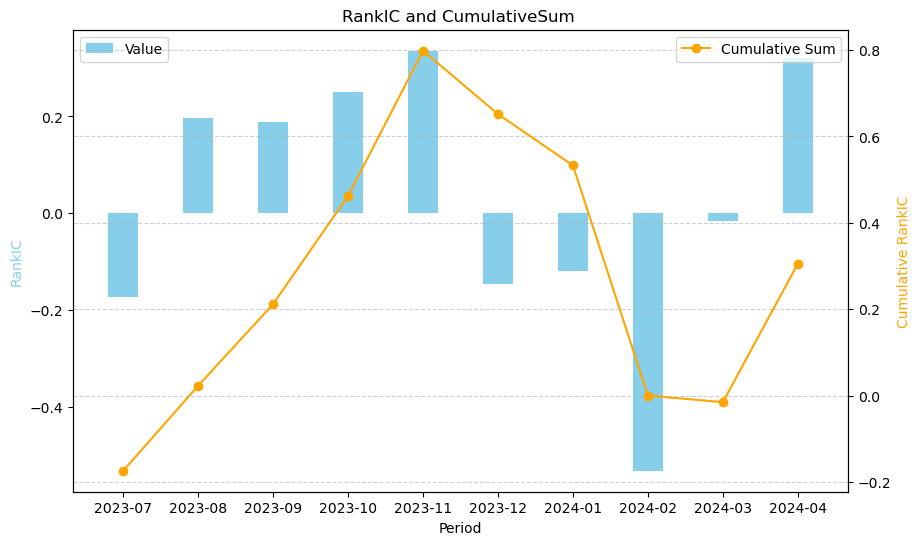

In [29]:
results_df=pd.read_csv('rank_ic_results_8.6_2.0.csv')# 去掉 "to" 后面的部分
results_df['Test_Period'] = results_df['Test_Period'].str.split(' to ').str[0]
results_df
cumulative_sum = results_df['RankIC'].cumsum()

# 创建图形和轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制柱状图
ax1.bar(results_df['Test_Period'],results_df['RankIC'], color='skyblue', label='Value', width=0.4, align='center')

# 创建第二个y轴用于绘制折线图
ax2 = ax1.twinx()
ax2.plot(results_df['Test_Period'], cumulative_sum, color='orange', marker='o', label='Cumulative Sum')

# 设置标签和标题
ax1.set_xlabel('Period')
ax1.set_ylabel('RankIC', color='skyblue')
ax2.set_ylabel('Cumulative RankIC', color='orange')
plt.title('RankIC and CumulativeSum ')
plt.xticks(rotation=45)
# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图形
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### T,T+3,T+4, topn=1000

In [34]:
calculate_rankic_and_save_results('2023-04-01', '2024-04-30', 'rank_ic_results_8.6_2.0_topn=1000.csv')

报告期: 2023-03-31
构建期: 2023-04-01 至 2023-06-30
测试期: 2023-07-01 至 2023-07-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-03-31
构建期: 2023-05-01 至 2023-07-31
测试期: 2023-08-01 至 2023-08-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-03-31
构建期: 2023-06-01 至 2023-08-31
测试期: 2023-09-01 至 2023-09-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-06-30
构建期: 2023-07-01 至 2023-09-30
测试期: 2023-10-01 至 2023-10-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-06-30
构建期: 2023-08-01 至 2023-10-31
测试期: 2023-11-01 至 2023-11-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-06-30
构建期: 2023-09-01 至 2023-11-30
测试期: 2023-12-01 至 2023-12-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-09-30
构建期: 2023-10-01 至 2023-12-31
测试期: 2024-01-01 至 2024-01-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-09-30
构建期: 2023-11-01 至 2024-01-31
测试期: 2024-02-01 至 2024-02-29


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-09-30
构建期: 2023-12-01 至 2024-02-29
测试期: 2024-03-01 至 2024-03-31


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

报告期: 2023-12-31
构建期: 2024-01-01 至 2024-03-31
测试期: 2024-04-01 至 2024-04-30


/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Daily_Return'] = filtered_data.groupby('S_INFO_WINDCODE')['S_DQ_ADJCLOSE'].pct_change()
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/3984586875.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['Daily_Return'], inplace=True)
/var/folders/fj/qfgcy6_x669fxrp49s5jltzh0000gn/T/ipykernel_68409/2758545255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of

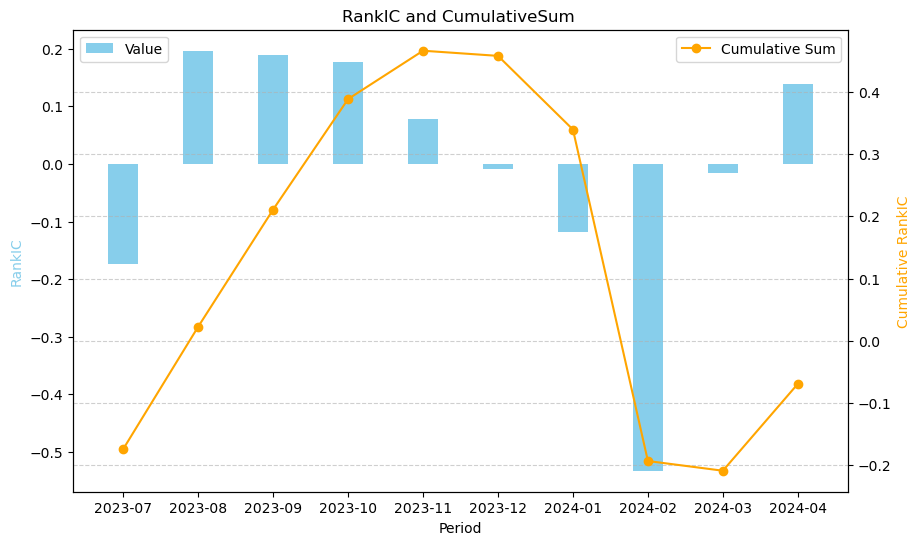

In [35]:
results_df=pd.read_csv('rank_ic_results_8.6_2.0_topn=1000.csv')# 去掉 "to" 后面的部分
results_df['Test_Period'] = results_df['Test_Period'].str.split(' to ').str[0]
results_df
cumulative_sum = results_df['RankIC'].cumsum()

# 创建图形和轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制柱状图
ax1.bar(results_df['Test_Period'],results_df['RankIC'], color='skyblue', label='Value', width=0.4, align='center')

# 创建第二个y轴用于绘制折线图
ax2 = ax1.twinx()
ax2.plot(results_df['Test_Period'], cumulative_sum, color='orange', marker='o', label='Cumulative Sum')

# 设置标签和标题
ax1.set_xlabel('Period')
ax1.set_ylabel('RankIC', color='skyblue')
ax2.set_ylabel('Cumulative RankIC', color='orange')
plt.title('RankIC and CumulativeSum ')
plt.xticks(rotation=45)
# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图形
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()